# Assignment


In [1]:
import pandas as pd
import geopandas as gpd
import psycopg2
import json
from sqlalchemy import create_engine, text
from sqlalchemy.types import Integer, String
from shapely.geometry import shape
import matplotlib.pyplot as plt
import seaborn as sns

## Clear data

Collate the data in SA2.zip to obtain the SA2code, SA2name data content and gccreated information. And filter out the line where the blank coordinate information is located, and add a placeholder "0" to the content containing the missing value to prevent the future use of this data. Finally, check that all geometry objects in the Geometry column are valid and have no duplicates.

In [2]:
SA2 = gpd.read_file("SA2/SA2_2021_AUST_GDA2020.shp")
columns_to_keep = ['SA2_CODE21', 'SA2_NAME21','GCC_CODE21', 'GCC_NAME21', 'geometry']
SA2 = SA2[columns_to_keep]
# Canonical column name
SA2.rename(columns={'SA2_CODE21': 'sa2_code'}, inplace=True)
SA2.rename(columns={'SA2_NAME21': 'sa2_name'}, inplace=True)
SA2.rename(columns={'GCC_CODE21': 'gcc_code'}, inplace=True)
SA2.rename(columns={'GCC_NAME21': 'gcc_name'}, inplace=True)
SA2.dropna(subset=['geometry'], inplace=True)
SA2.fillna(value=0, inplace=True)
SA2.drop_duplicates(subset=['geometry'], inplace=True)
valid_geom = SA2['geometry'].apply(lambda x: shape(x).is_valid)
SA2 = SA2[valid_geom]

Collate the data in "Stops.txt",some content that was not relevant for later analysis was deleted, leaving the content related to the platforms in the database and their latitude and longitude data.

In [3]:
Stops = pd.read_csv("Stops.txt", delimiter=",")
columns_to_keep = ['stop_id','stop_code','stop_name', 'stop_lat','stop_lon']
Stops = Stops[columns_to_keep]
# Canonical column name
Stops.rename(columns={'stop_lat': 'latitude'}, inplace=True)
Stops.rename(columns={'stop_lon': 'longitude'}, inplace=True)

Collate the data in "Businesses.csv", convert the data content to the corresponding data format,and filtered the data, keeping only data on industry type, sa2 and total number of businesses.And check if the value of SA2 is valid.

In [4]:
Businesses =  pd.read_csv('Businesses.csv')
Businesses['total_businesses'] = Businesses['total_businesses'].astype(int)
columns_to_keep = ['industry_code','industry_name','sa2_code','sa2_name','total_businesses']
Businesses = Businesses[columns_to_keep]
compare = SA2['sa2_code'].astype(int)
Businesses['match'] = Businesses['sa2_code'].isin(compare)
Businesses = Businesses[Businesses['match'] == True].drop(columns=['match'])

After sorting out the data in "PollingPlaces2019.csv", I deleted some column names not related to the later analysis, and deleted the data with blank and duplicate coordinates. For some rows with missing information, I chose to add a 0 as a placeholder, because these data may be related to the following, and reserved some information.

In [5]:
Polls = pd.read_csv("PollingPlaces2019.csv")
Polls.drop_duplicates(subset=['the_geom'], inplace=True)
columns_to_keep = ['polling_place_id','polling_place_name','latitude','longitude']
Polls = Polls[columns_to_keep]
Polls.dropna(subset=['latitude','longitude'], inplace=True)
Polls.fillna(value=0, inplace=True)

Collate the data in "Catchments.zip", combine the three data tables into one data table, because in task2, people from 0-19 years old are combined as "young people", so "CATCH_TYPE", "ADD_DATE", "KINDERGART", "young people", and so on. The "YEAR1-12" columns are all deleted. Only the columns USE_ID, USE_DESC, and geometry are reserved. And filter out the line where the blank coordinate information is located, for some missing information, I choose to add a 0 as a placeholder, because these data may be related to the following, giving some information retention. Finally, check that all geometry objects in the Geometry column are valid and not duplicated, and convert CRS to 7844

In [6]:
School_future = gpd.read_file("Catchments/catchments/catchments_future.shp")
School_primary = gpd.read_file("Catchments/catchments/catchments_primary.shp")
School_secondary = gpd.read_file("Catchments/catchments/catchments_secondary.shp")
merged_schools = gpd.GeoDataFrame(pd.concat([School_future, School_primary, School_secondary], ignore_index=True))
columns_to_keep = ['USE_ID','USE_DESC','geometry']
School = merged_schools[columns_to_keep].copy()
School['USE_ID'] = School['USE_ID'].astype(int)
School.dropna(subset=['geometry'], inplace=True)
School.fillna(value=0, inplace=True)

School.drop_duplicates(subset=['geometry'], inplace=True)
School.drop_duplicates(subset=['USE_ID'], inplace=True)

valid_geom = School['geometry'].apply(lambda x: shape(x).is_valid)
School = School[valid_geom]

School['geometry'] = School['geometry'].to_crs(epsg=7844)

# Canonical column name
School.rename(columns={'USE_ID': 'use_id'}, inplace=True)
School.rename(columns={'USE_DESC': 'use_desc'}, inplace=True)

Collate the data in "Population.csv", convert the data content to the corresponding data format, and add a column named "young_people" to record young people aged 0-19 in the current region.

In [7]:
Population = pd.read_csv("Population.csv")

Population['0-4_people'] = Population['0-4_people'].astype(int)
Population['5-9_people'] = Population['5-9_people'].astype(int)
Population['10-14_people'] = Population['10-14_people'].astype(int)
Population['15-19_people'] = Population['15-19_people'].astype(int)

young_people = Population['0-4_people'] + Population['5-9_people'] + Population['10-14_people'] + Population['15-19_people']
Population['young_people'] = young_people

Population['sa2_code'] = Population['sa2_code'].astype(int)
Population['total_people'] = Population['total_people'].astype(int)
columns_to_keep = ['sa2_code','sa2_name','young_people','total_people']
Population = Population[columns_to_keep]

Collate the data in "incomes.csv", convert the data content into the corresponding data format, clear the abnormal information, and add the column "total_income" to record the total Income in the current region.

In [8]:
Income = pd.read_csv("Income.csv")

contains_np = Income.apply(lambda row: 'np' in row.values, axis=1)
Income = Income[~contains_np]

Income['earners'] = Income['earners'].astype(int)
Income['mean_income'] = Income['mean_income'].astype(int)
total_income = Income['earners'] * Income['mean_income']
Income['total_income'] = total_income
# Canonical column name
Income.rename(columns={'sa2_code21': 'sa2_code'}, inplace=True)


## Import all datasets  PostgreSQL server

Use the pgconnect function to connect to the PostgreSQL server and load the PostGIS extension.

In [9]:
def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

In [10]:
credentials = "Credentials.json"
db, conn = pgconnect(credentials)

Connected successfully.


In [11]:
conn.execute("CREATE EXTENSION IF NOT EXISTS postgis;")

Create the structure of the table, define foreign keys and primary keys to establish associations between different tables.

In [12]:
# SA2
db.execute('''
CREATE TABLE sa2 (
    sa2_code VARCHAR(255) PRIMARY KEY,
    sa2_name VARCHAR(255),
    gcc_code VARCHAR(255),
    gcc_name VARCHAR(255),
    geometry geometry(MULTIPOLYGON, 7844),
    zbusinesses FLOAT,  
    zpolls FLOAT,      
    zstops FLOAT,       
    zschools FLOAT
)
''')

ProgrammingError: (psycopg2.errors.DuplicateTable) relation "sa2" already exists

[SQL: 
CREATE TABLE sa2 (
    sa2_code VARCHAR(255) PRIMARY KEY,
    sa2_name VARCHAR(255),
    gcc_code VARCHAR(255),
    gcc_name VARCHAR(255),
    geometry geometry(MULTIPOLYGON, 7844),
    zbusinesses FLOAT,  
    zpolls FLOAT,      
    zstops FLOAT,       
    zschools FLOAT
)
]
(Background on this error at: https://sqlalche.me/e/14/f405)

In [23]:
# Stops
db.execute('''
CREATE TABLE stops (
    stop_id VARCHAR(255) PRIMARY KEY,
    stop_code VARCHAR(255),
    stop_name VARCHAR(255),
    latitude FLOAT,
    longitude FLOAT,
    sa2_code VARCHAR(255),
    FOREIGN KEY (sa2_code) REFERENCES SA2(sa2_code)
)
''')

In [24]:
# Businesses
db.execute('''
CREATE TABLE businesses (
    businesses_id SERIAL PRIMARY KEY,
    industry_code VARCHAR(255),
    industry_name VARCHAR(255),
    sa2_code VARCHAR(255),
    sa2_name VARCHAR(255),
    total_businesses INTEGER,
    FOREIGN KEY (sa2_code) REFERENCES SA2(sa2_code)
)
''')

In [25]:
# Polls
db.execute('''
CREATE TABLE polls (
    polling_place_id INTEGER PRIMARY KEY,
    polling_place_name VARCHAR(255),
    latitude FLOAT,
    longitude FLOAT,
    sa2_code VARCHAR(255),
    FOREIGN KEY (sa2_code) REFERENCES SA2(sa2_code)
)
''')

In [26]:
# School
db.execute('''
CREATE TABLE school (
    use_id INTEGER PRIMARY KEY,
    use_desc VARCHAR(255),
    geometry geometry(MULTIPOLYGON, 7844),
    sa2_code VARCHAR(255),
    FOREIGN KEY (sa2_code) REFERENCES SA2(sa2_code)
)
''')

In [27]:
# Population
db.execute('''
CREATE TABLE population (
    sa2_code VARCHAR(255),
    sa2_name VARCHAR(255),
    young_people INTEGER,
    total_people INTEGER,
    PRIMARY KEY (sa2_name),
    FOREIGN KEY (sa2_code) REFERENCES SA2(sa2_code)
)
''')

In [28]:
# Income
db.execute('''
CREATE TABLE income (
    sa2_code VARCHAR(255),
    sa2_name VARCHAR(255),
    earners INTEGER,
    median_age FLOAT,
    median_income FLOAT,
    mean_income FLOAT,
    total_income FLOAT,
    PRIMARY KEY (sa2_name),
    FOREIGN KEY (sa2_code) REFERENCES SA2(sa2_code)
)
''')

In the Businesses, Population, and Income tables, the SA2_code column is defined as a foreign key, which references the SA2_code column in the SA2 table as the primary key. This establishes an association between these tables.

Load the cleaned data to the server one by one.

In [29]:
SA2.to_postgis('sa2', db, index=False,if_exists='append')

In [30]:
Polls.to_sql('polls', db, index=False, if_exists='append')

543

In [31]:
Population.to_sql('population', db, index=False, if_exists='append')

373

In [32]:
Income.to_sql('income', db, index=False, if_exists='append')

635

In [33]:
Stops.to_sql('stops', db, index=False, if_exists='append')

718

In [34]:
School.to_postgis('school', db, index=False, if_exists='append')

In [35]:
Businesses.to_sql('businesses', db, index=False, if_exists='append')

198

Next, the corresponding geometry information is generated by obtaining the latitude and longitude from the site table, poll table, and school table, and the corresponding sa2_code is obtained by matching the coordinate information with the geometry in the sa2 table. If sa2 does not match the content, the data is deleted.

In [36]:
db.execute('''
ALTER TABLE Stops
ADD COLUMN geom GEOMETRY(Point, 4326);
UPDATE Stops
SET geom = ST_SetSRID(ST_MakePoint(longitude, latitude), 4326);
ALTER TABLE Stops
ADD COLUMN geometry_7844 GEOMETRY(Point, 7844);
UPDATE Stops
SET geometry_7844 = ST_Transform(geom, 7844);

UPDATE Stops s
SET sa2_code = sa2.sa2_code
FROM SA2 sa2
WHERE ST_Within(s.geometry_7844, sa2.geometry);

DELETE FROM Stops
WHERE sa2_code IS NULL;

ALTER TABLE Stops
DROP COLUMN geom;
ALTER TABLE Stops
DROP COLUMN geometry_7844;
''')

In [37]:
db.execute('''
ALTER TABLE Polls
ADD COLUMN geom GEOMETRY(Point, 4326);
UPDATE Polls
SET geom = ST_SetSRID(ST_MakePoint(longitude, latitude), 4326);
ALTER TABLE Polls
ADD COLUMN geometry_7844 GEOMETRY(Point, 7844);
UPDATE Polls
SET geometry_7844 = ST_Transform(geom, 7844);

UPDATE Polls p
SET sa2_code = sa2.sa2_code
FROM SA2 sa2
WHERE ST_Within(p.geometry_7844, sa2.geometry);

DELETE FROM Polls
WHERE sa2_code IS NULL;

ALTER TABLE Polls
DROP COLUMN geom;
ALTER TABLE Polls
DROP COLUMN geometry_7844;
''')

In [38]:
db.execute('''
UPDATE School s
SET SA2_code = sa2.SA2_code
FROM SA2 sa2
WHERE ST_Within(s.geometry, sa2.geometry);

DELETE FROM School
WHERE sa2_code IS NULL;
''')

# Calculate the Zbusiness

Extract data from database  only calculate scores for SA2 regions with a population of at least 100，which industries are "Accommodation and Food Services" and "Information Media and Telecommunications". Then calculate the total number of businesses in these industries in each SA2 region. What's more, How busy Accommodation and Food Services are is a direct indicator of how attractive and active an area is, The active degree of Information Media and Telecommunications can reflect the degree of regional technology and information mobility, and is an indicator of the vitality of modern cities.

After that, the z-score formula is given by $z = \frac{X - \mu}{\sigma}$, where $X$ is the value, $\mu$ is the mean, and $\sigma$ is the standard deviation.

The window function OVER() is used here to calculate the mean and standard deviation of all selected data

In [16]:
db.execute('''
CREATE TEMP TABLE temp_zbusinesses (
    sa2_code VARCHAR(255),
    zbusiness FLOAT
);
INSERT INTO temp_zbusinesses (sa2_code, zbusiness)
WITH selected AS (
    SELECT
        sa2.sa2_code,
        COALESCE(SUM(b.total_businesses), 0) AS selected_industries
    FROM
        sa2
    LEFT JOIN businesses b ON sa2.sa2_code = b.sa2_code 
        AND b.industry_name IN ('Accommodation and Food Services', 'Information Media and Telecommunications')
    LEFT JOIN Population pop ON sa2.sa2_code = pop.sa2_code
    WHERE
        pop.total_people >= 100 OR pop.total_people IS NULL
    GROUP BY 
        sa2.sa2_code
),
stats AS (
    SELECT
        sa2_code,
        selected_industries,
        AVG(selected_industries) OVER() AS avg_industries,
        STDDEV(selected_industries) OVER() AS stddev_industries
    FROM selected
)
SELECT
    sa2_code,
    CASE
        WHEN stddev_industries = 0 THEN 0
        ELSE (selected_industries - avg_industries) / stddev_industries
    END AS zbusiness
FROM stats;
UPDATE sa2
SET zbusinesses = (
    SELECT zbusiness
    FROM temp_zbusinesses
    WHERE temp_zbusinesses.sa2_code = sa2.sa2_code
);
DROP TABLE IF EXISTS temp_zbusinesses;
''')

In [17]:
zbusiness = db.execute('''
SELECT sa2_code, sa2_name, zbusinesses
FROM sa2;
''')

for row in zbusiness:
    sa2_code = row[0]
    sa2_name = row[1]
    zbusiness = row[2]
    print(f"SA2 Code: {sa2_code}, SA2 Name: {sa2_name}, Z-Business: {zbusiness}")

SA2 Code: 103011059, SA2 Name: Bathurst - East, Z-Business: 0.18361585251498938
SA2 Code: 103011060, SA2 Name: Bathurst Surrounds, Z-Business: 0.16654522881034703
SA2 Code: 507041181, SA2 Name: Melville, Z-Business: -0.3285028586242806
SA2 Code: 101021007, SA2 Name: Braidwood, Z-Business: 0.2518983473335587
SA2 Code: 504031068, SA2 Name: The Vines, Z-Business: -0.3285028586242806
SA2 Code: 504031069, SA2 Name: Walyunga National Park, Z-Business: -0.3285028586242806
SA2 Code: 104021089, SA2 Name: Sawtell - Boambee, Z-Business: 0.9347232955192519
SA2 Code: 104021091, SA2 Name: Woolgoolga - Arrawarra, Z-Business: 0.7981583058821133
SA2 Code: 105011092, SA2 Name: Bourke - Brewarrina, Z-Business: 0.11533335769642004
SA2 Code: 105011094, SA2 Name: Coonamble, Z-Business: 0.06412148658249305
SA2 Code: 105011095, SA2 Name: Nyngan - Warren, Z-Business: 0.16654522881034703
SA2 Code: 105011096, SA2 Name: Walgett - Lightning Ridge, Z-Business: 0.38846333697069735
SA2 Code: 105021097, SA2 Name: Brok

# Calculate the Zstops

Zstops used to quantify the standardised deviation of the number of public transport stops in each SA2 region relative to the average number of stops throughout the Sydney region

the z-score formula is given by $z = \frac{X - \mu}{\sigma}$, where $X$ is the value, $\mu$ is the mean, and $\sigma$ is the standard deviation.

The window function OVER() is used here to calculate the mean and standard deviation of all selected data

In [18]:
db.execute('''
CREATE TEMP TABLE temp_zstops (
    sa2_code VARCHAR(255),
    zstop FLOAT
);
INSERT INTO temp_zstops (sa2_code, zstop)
WITH stop_counts AS (
    SELECT
        sa2.sa2_code,
        COALESCE(COUNT(s.stop_id), 0) AS total_stops
    FROM 
        sa2
    LEFT JOIN stops s ON sa2.sa2_code = s.sa2_code
    LEFT JOIN Population p ON sa2.sa2_code = p.sa2_code
    WHERE p.total_people >= 100 OR p.total_people IS NULL
    GROUP BY sa2.sa2_code
),
stats AS (
    SELECT
        sa2_code,
        total_stops,
        AVG(total_stops) OVER() AS avg_stops,
        STDDEV(total_stops) OVER() AS stddev_stops
    FROM stop_counts
)
SELECT
    sa2_code,
    CASE
        WHEN stddev_stops = 0 THEN 0
        ELSE (total_stops - avg_stops) / stddev_stops
    END AS zstop
FROM stats;
UPDATE sa2
SET zstops = (
    SELECT zstop
    FROM temp_zstops
    WHERE temp_zstops.sa2_code = sa2.sa2_code
);
DROP TABLE IF EXISTS temp_zstops;

''')

In [19]:
zstop = db.execute('''
SELECT sa2_code, zstops
FROM sa2;
''')

for row in zstop:
    sa2_code = row[0]
    zstop = row[1]
    print(f"SA2 Code: {sa2_code}, Z-stop: {zstop}")

SA2 Code: 103011059, Z-stop: 2.742682101577341
SA2 Code: 103011060, Z-stop: 7.087759571637375
SA2 Code: 507041181, Z-stop: -0.3907872277928761
SA2 Code: 101021007, Z-stop: 3.1771898485833443
SA2 Code: 504031068, Z-stop: -0.3907872277928761
SA2 Code: 104021089, Z-stop: 2.4752927188044156
SA2 Code: 504031069, Z-stop: -0.3907872277928761
SA2 Code: 104021091, Z-stop: 3.1771898485833443
SA2 Code: 105011092, Z-stop: -0.3239398820996448
SA2 Code: 105011094, Z-stop: 0.2359066380811673
SA2 Code: 105011095, Z-stop: 0.7623294854153637
SA2 Code: 105011096, Z-stop: -0.3406517185229527
SA2 Code: 105021097, Z-stop: 1.113278050304828
SA2 Code: 105021098, Z-stop: -0.19024519071318222
SA2 Code: 105031099, Z-stop: -0.307228045676337
SA2 Code: 105031100, Z-stop: 4.7481024723742795
SA2 Code: 101021611, Z-stop: 4.230035543251737
SA2 Code: 101031013, Z-stop: -0.3573635549462605
SA2 Code: 101031014, Z-stop: 0.1105678649063586
SA2 Code: 101031015, Z-stop: -0.3406517185229527
SA2 Code: 101031016, Z-stop: -0.323

# Calculate the Zpolls

Zpolls assess the standard deviation of the number of polling stations in each SA2 region from the average of the entire dataset.

the z-score formula is given by $z = \frac{X - \mu}{\sigma}$, where $X$ is the value, $\mu$ is the mean, and $\sigma$ is the standard deviation.

The window function OVER() is used here to calculate the mean and standard deviation of all selected data

In [20]:
db.execute('''
CREATE TEMP TABLE temp_zpolls (
    sa2_code VARCHAR(255),
    zpolls FLOAT
);

INSERT INTO temp_zpolls (sa2_code, zpolls)
WITH poll_counts AS (
    SELECT
        sa2.sa2_code,
        COALESCE(COUNT(p.polling_place_id), 0) AS total_polls
    FROM 
        sa2
    LEFT JOIN polls p ON sa2.sa2_code = p.sa2_code
    LEFT JOIN Population pop ON sa2.sa2_code = pop.sa2_code
    WHERE pop.total_people >= 100 OR pop.total_people IS NULL
    GROUP BY sa2.sa2_code
),
stats AS (
    SELECT
        sa2_code,
        total_polls,
        AVG(total_polls) OVER() AS avg_polls,
        STDDEV(total_polls) OVER() AS stddev_polls
    FROM poll_counts
)
SELECT
    sa2_code,
    CASE
        WHEN stddev_polls = 0 THEN 0
        ELSE (total_polls - avg_polls) / stddev_polls
    END AS zpolls
FROM stats;

UPDATE sa2
SET zpolls = (
    SELECT zpolls
    FROM temp_zpolls
    WHERE temp_zpolls.sa2_code = sa2.sa2_code
);

DROP TABLE IF EXISTS temp_zpolls;
''')

In [21]:
zpoll = db.execute('''
SELECT sa2_code, zpolls
FROM sa2;
''')

for row in zpoll:
    sa2_code = row[0]
    zpoll = row[1]
    print(f"SA2 Code: {sa2_code}, Z-poll: {zpoll}")

SA2 Code: 103011059, Z-poll: 0.4523005829087755
SA2 Code: 103011060, Z-poll: 3.2820290482150236
SA2 Code: 507041181, Z-poll: -0.4909422388599738
SA2 Code: 101021007, Z-poll: 0.9239219937931501
SA2 Code: 104021089, Z-poll: 2.338786226446274
SA2 Code: 104021091, Z-poll: 1.8671648155618994
SA2 Code: 105011092, Z-poll: 0.9239219937931501
SA2 Code: 105011094, Z-poll: 0.4523005829087755
SA2 Code: 105011095, Z-poll: 1.3955434046775248
SA2 Code: 105011096, Z-poll: 2.338786226446274
SA2 Code: 105021098, Z-poll: 0.4523005829087755
SA2 Code: 105031099, Z-poll: 2.338786226446274
SA2 Code: 105031100, Z-poll: 0.9239219937931501
SA2 Code: 101021611, Z-poll: 2.338786226446274
SA2 Code: 101031013, Z-poll: 0.4523005829087755
SA2 Code: 101031014, Z-poll: 0.9239219937931501
SA2 Code: 101031016, Z-poll: 2.338786226446274
SA2 Code: 101041017, Z-poll: 0.9239219937931501
SA2 Code: 101041018, Z-poll: 0.4523005829087755
SA2 Code: 101041019, Z-poll: 1.3955434046775248
SA2 Code: 101041021, Z-poll: 0.4523005829087

# Calculate the Zschools

Zschools uses a standardised approach to measure where the number of school catchments in each region compares to the average for the entire Sydney region. This can help identify which regions are relatively rich in educational resources and which may need more attention and resource input.

the z-score formula is given by $z = \frac{X - \mu}{\sigma}$, where $X$ is the value, $\mu$ is the mean, and $\sigma$ is the standard deviation.

The window function OVER() is used here to calculate the mean and standard deviation of all selected data

In [22]:
db.execute('''
CREATE TEMP TABLE temp_zschools (
    sa2_code VARCHAR(255),
    zschools FLOAT
);

INSERT INTO temp_zschools (sa2_code, zschools)
WITH school_counts AS (
    SELECT 
        sa2.sa2_code, 
        COALESCE(COUNT(s.use_id), 0) AS total_schools
    FROM 
        sa2
    LEFT JOIN school s ON sa2.sa2_code = s.sa2_code
    LEFT JOIN Population p ON sa2.sa2_code = p.sa2_code
    WHERE p.total_people >= 100 OR p.total_people IS NULL
    GROUP BY
        sa2.sa2_code
),
stats AS (
    SELECT
        sa2_code,
        total_schools,
        AVG(total_schools) OVER() AS avg_schools,
        STDDEV(total_schools) OVER() AS stddev_schools
    FROM school_counts
)
SELECT
    sa2_code,
    CASE
        WHEN stddev_schools = 0 THEN 0
        ELSE (total_schools - avg_schools) / stddev_schools
    END AS zschools
FROM stats;

UPDATE sa2
SET zschools = (
    SELECT zschools
    FROM temp_zschools
    WHERE temp_zschools.sa2_code = sa2.sa2_code
);

DROP TABLE IF EXISTS temp_zschools;
''')

In [23]:
zschools = db.execute('''
SELECT sa2_code, zschools
FROM sa2;
''')

for row in zschools:
    sa2_code = row[0]
    zschool = row[1]
    print(f"SA2 Code: {sa2_code}, Z-school: {zschool}")

SA2 Code: 103011059, Z-school: -0.13429495002999384
SA2 Code: 103011060, Z-school: -0.13429495002999384
SA2 Code: 507041181, Z-school: -0.13429495002999384
SA2 Code: 114011283, Z-school: -0.13429495002999384
SA2 Code: 101021007, Z-school: -0.13429495002999384
SA2 Code: 303041067, Z-school: -0.13429495002999384
SA2 Code: 212031303, Z-school: -0.13429495002999384
SA2 Code: 801051055, Z-school: -0.13429495002999384
SA2 Code: 104021089, Z-school: 3.2107455910232203
SA2 Code: 404021099, Z-school: -0.13429495002999384
SA2 Code: 104021091, Z-school: -0.13429495002999384
SA2 Code: 105011092, Z-school: 3.2107455910232203
SA2 Code: 105011094, Z-school: -0.13429495002999384
SA2 Code: 105011095, Z-school: -0.13429495002999384
SA2 Code: 105011096, Z-school: -0.13429495002999384
SA2 Code: 105021098, Z-school: 3.2107455910232203
SA2 Code: 105031099, Z-school: -0.13429495002999384
SA2 Code: 105031100, Z-school: -0.13429495002999384
SA2 Code: 101021611, Z-school: -0.13429495002999384
SA2 Code: 10103101

# Calculate the Sigmoid function

Calculate the resource richness score of each community through the Sigmoid function.

In [5]:
db.execute('''
ALTER TABLE sa2 ADD COLUMN score FLOAT;
UPDATE sa2
SET score = 1.0 / (1.0 + EXP(-(COALESCE(zbusinesses, 0) + COALESCE(zstops, 0) + COALESCE(zpolls, 0) + COALESCE(zschools, 0))));

''')

In [25]:
score = db.execute('''
SELECT sa2_code, score
FROM sa2;
''')

for row in score:
    sa2_code = row[0]
    score = row[1]
    print(f"SA2 Code: {sa2_code}, score: {score}")

SA2 Code: 103011059, score: 0.9624678797286744
SA2 Code: 103011060, score: 0.9999696304248662
SA2 Code: 507041181, score: 0.20676653562166
SA2 Code: 114011283, score: 0.7602202121099719
SA2 Code: 101021007, score: 0.9854959234631293
SA2 Code: 303041067, score: 0.20676653562166
SA2 Code: 104021089, score: 0.9998715121650659
SA2 Code: 104021091, score: 0.9966923956288963
SA2 Code: 105011092, score: 0.9806602036187695
SA2 Code: 105011094, score: 0.6497712254445265
SA2 Code: 105011095, score: 0.8993590552878187
SA2 Code: 105011096, score: 0.9048489930538773
SA2 Code: 105021098, score: 0.967178105574706
SA2 Code: 105031099, score: 0.9292961319905402
SA2 Code: 101031016, score: 0.993641136182613
SA2 Code: 101041017, score: 0.8317501748766949
SA2 Code: 101041018, score: 0.6509134457159262
SA2 Code: 101041019, score: 0.9918725338493943
SA2 Code: 101041021, score: 0.5266070450595253
SA2 Code: 101041020, score: 0.9999592699511823
SA2 Code: 101041022, score: 0.20676653562166
SA2 Code: 101041023, 

# Part 3

For team member Fan Bo, I got the data from opendata about the rest area in New South China State, which is a data group containing spatial data. For this data, I first clear it until only a few columns about "bustling" information and the spatial coordinates of each rest area remain.

In [39]:
rest_area = pd.read_csv('nsw_rest_area.csv')
columns_to_keep = ['rest_area_name', 'rest_area_number','latitude','longitude']
rest_area = rest_area[columns_to_keep]
# Canonical column name
rest_area.rename(columns={'rest_area_name': 'rest_name'}, inplace=True)
rest_area.rename(columns={'rest_area_number': 'rest_id'}, inplace=True)

I then created a new rest table in the data server, including the rest area name and spatial location. The primary key for this table is the rest_id column, and the foreign key is sa2_code to associate with the sa2 table.

In [40]:
# parking
db.execute('''
CREATE TABLE rest (
    rest_name VARCHAR(255),
    rest_id VARCHAR(255) PRIMARY KEY,
    latitude FLOAT,
    longitude FLOAT,
    sa2_code VARCHAR(255),
    FOREIGN KEY (sa2_code) REFERENCES SA2(sa2_code)
)
''')

In [41]:
rest_area.to_sql('rest', db, index=False, if_exists='append')

822

For sa2code in the rest table, I first created a temporary geom column to keep the coordinates, and then changed the EPSG to 7844, which is consistent with the sa2 table, and saved it to the geometry column. Finally, this column is matched against the geometry in sa2 to find the corresponding sa2code.

In [42]:
db.execute('''
ALTER TABLE rest
ADD COLUMN geom GEOMETRY(Point, 4326);
UPDATE rest
SET geom = ST_SetSRID(ST_MakePoint(longitude, latitude), 4326);
ALTER TABLE rest
ADD COLUMN geometry GEOMETRY(Point, 7844);
UPDATE rest
SET geometry = ST_Transform(geom, 7844);

UPDATE rest s
SET sa2_code = sa2.sa2_code
FROM SA2 sa2
WHERE ST_Within(s.geometry, sa2.geometry);

DELETE FROM rest
WHERE sa2_code IS NULL;

ALTER TABLE rest
DROP COLUMN geom;
''')

For rest Z-scores, I first index the sa2_code column in the rest, population and sa2 tables to improve the performance of querying this column information,  and then add a new column named Zrest in the SA2 table to store the Z-scores. Create three more tables to store the number, areas with a population greater than 100, mean and standard deviation of rest stops in each SA2 area.Finally join the two temporary tables to calculate the final Z-score($z = \frac{X - \mu}{\sigma}$, where $X$ is the value, $\mu$ is the mean, and $\sigma$ is the standard deviation.) , and updates the results to the Zrest column of the SA2 table. Delete three more temporary tables.

In [6]:
db.execute('''
CREATE INDEX idx_rest_sa2_code ON rest(sa2_code);
CREATE INDEX idx_sa2_sa2_code ON sa2(sa2_code);
CREATE INDEX idx_population_sa2_code ON population(sa2_code);

ALTER TABLE sa2 ADD COLUMN zrest FLOAT;

CREATE TEMP TABLE sa2_population_gt_100 AS
    SELECT sa2_code
    FROM population
    GROUP BY sa2_code
    HAVING SUM(total_people) > 100;

CREATE TEMP TABLE rest_counts AS
    SELECT sa2_code, COUNT(*) AS rest_count
    FROM rest
    WHERE sa2_code IN (SELECT sa2_code FROM sa2_population_gt_100)
    GROUP BY sa2_code;
    
CREATE TEMP TABLE stats AS
    SELECT AVG(rest_count) AS avg_rest_count, STDDEV(rest_count) AS stddev_rest_count
    FROM rest_counts;

UPDATE sa2
SET zrest = (rc.rest_count - s.avg_rest_count) / s.stddev_rest_count
FROM rest_counts rc
CROSS JOIN stats s
WHERE sa2.sa2_code = rc.sa2_code;

DROP TABLE IF EXISTS sa2_population_gt_100;
DROP TABLE IF EXISTS rest_counts;
DROP TABLE IF EXISTS stats;

''')

This new Zrest value is then added to the Score formula to calculate the S-values for these regions

In [7]:
db.execute('''
UPDATE sa2
SET score = 1 / (1 + EXP(-(
    COALESCE(zbusinesses, 0) + 
    COALESCE(zstops, 0) + 
    COALESCE(zpolls, 0) + 
    COALESCE(zschools, 0) + 
    COALESCE(zrest, 0)
)))
''')

I then plotted the scores of the regions where sa2 appeared in the rest table, and the colors deepened with the higher the scores.

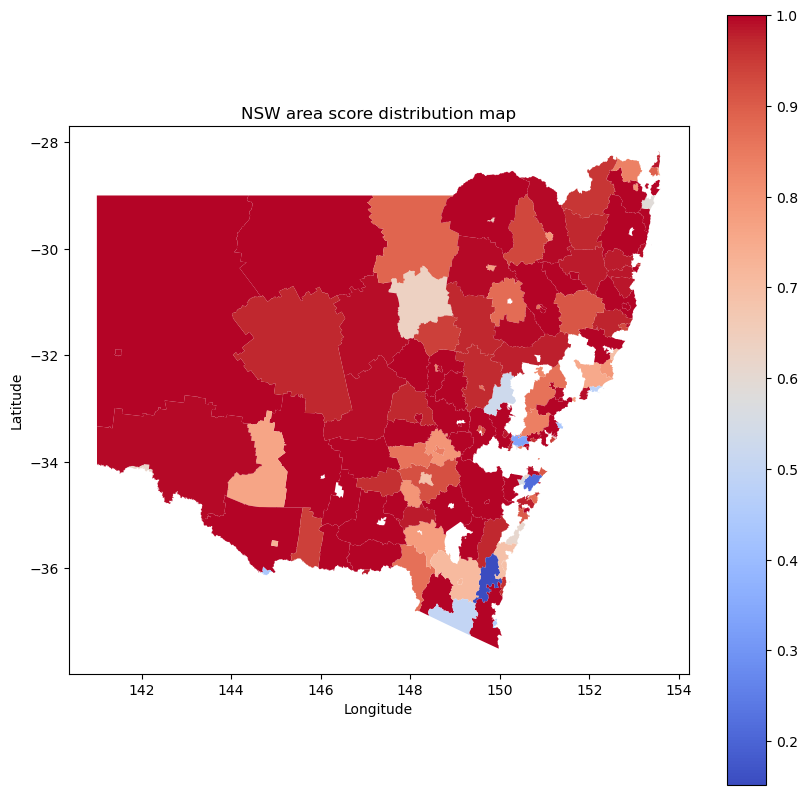

In [8]:
rest_data = gpd.read_postgis('SELECT * FROM rest', db, geom_col='geometry')
unique_sa2_codes = rest_data['sa2_code'].unique()
sa2_data = gpd.read_postgis(f'SELECT * FROM sa2 WHERE sa2_code IN {tuple(unique_sa2_codes)}', db, geom_col='geometry')
sa2_rest_data = gpd.sjoin(sa2_data, rest_data, how='inner', predicate='contains')
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sa2_data.plot(ax=ax, column='score', cmap='coolwarm', legend=True)

plt.title('NSW area score distribution map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

As can be seen from the above figure, first of all, larger areas usually get higher scores, while some cities near the sea have more developed tourism industry, so the government may set more rest areas for tourists, which leads to higher scores for bustiling. And for some of the northwest areas where the industrial industry is more prosperous, the government has set up more rest areas for these industrial personnel to ensure the safety of workers. Smaller, more inland areas may have fewer people, less demand for rest areas, and thus less prosperity.

Below I have generated a scatter plot of current scores and median incomes by region

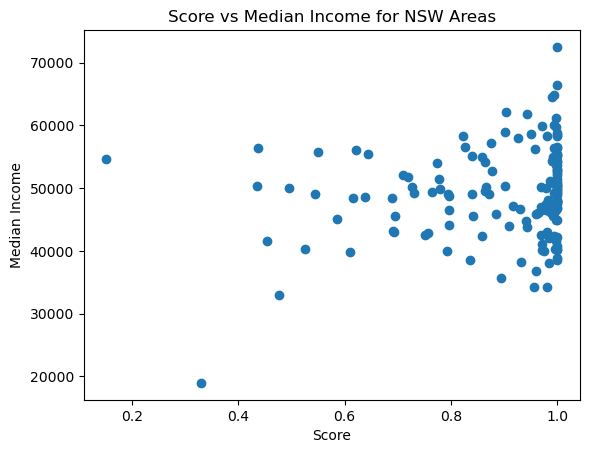

In [9]:
cursor = db.execute('''
SELECT sa2.sa2_name, sa2.score, income.median_income
FROM sa2
JOIN income ON sa2.sa2_code = income.sa2_code
WHERE sa2.sa2_name IN (SELECT sa2_name FROM sa2 WHERE zrest IS NOT NULL);
''')
data = pd.DataFrame(cursor.fetchall(), columns=["sa2_name", "score", "median_income"])
plt.scatter(data["score"], data["median_income"])
plt.xlabel("Score")
plt.ylabel("Median Income")
plt.title("Score vs Median Income for NSW Areas")
plt.show()

As we can see from this chart, the average income in most areas with a higher "bustling" score is above 50,000. Whereas areas with median incomes above 60,000 tend to be very prosperous (close to 1), areas with lower median incomes may not be as prosperous as areas with higher incomes. This relationship may be due to the fact that high-income regions generally have more economic opportunities and resources, and are able to support more business activity and employment opportunities, thus increasing prosperity.

# Part 3 - Sproperty

This part is generated by teammate WENWEI LU, I collected the data from AURIN and the data is about the property, the average rent from different area.

# Clean the data and create the table in database

In [13]:
property_data = pd.read_json('property.json', lines=True)
property_data = property_data[['sa22016code','sa22016name','sold_private_treaty_daysonmarketrecordcount',
             'auction_activity_auctionlistedcount',
             'auction_activity_auctiontotalsold',
             'for_rent_home_lease_averageprice',
             'for_sale_both_auction_private_treaty_averageprice',
             'sold_both_auction_private_treaty_averageprice',
             'gross_rental_yield']]
property_data = property_data.dropna()

In [14]:
db.execute('''
CREATE TABLE IF NOT EXISTS property (
    sa22016code VARCHAR(255),
    sa22016name VARCHAR(255),
    sold_private_treaty_daysonmarketrecordcount INT,
    auction_activity_auctionlistedcount INT,
    auction_activity_auctiontotalsold INT,
    for_rent_home_lease_averageprice FLOAT,
    for_sale_both_auction_private_treaty_averageprice FLOAT,
    sold_both_auction_private_treaty_averageprice FLOAT,
    gross_rental_yield FLOAT,
    FOREIGN KEY (sa22016code) REFERENCES sa2(sa2_code)
)
''')

In [15]:
property_data.to_sql('property', con=db, index=False, if_exists='replace')

396

# Caculate the Zproperty

In [16]:
Zproperty = db.execute('''
WITH price_stats AS (
    SELECT 
        sa22016code,
        for_rent_home_lease_averageprice,
        AVG(for_rent_home_lease_averageprice) OVER() AS avg_price,
        STDDEV(for_rent_home_lease_averageprice) OVER() AS std_price
    FROM 
        property
)

SELECT 
    sa22016code,
    (for_rent_home_lease_averageprice - avg_price) / NULLIF(std_price, 0) AS zscore
FROM 
    price_stats;
''')

for row in Zproperty:
    print(row)

(111031222, 0.9766195384116062)
(107031136, 1.2276347566815125)
(107031137, 0.6630021978132159)
(109011172, 0.015729883946082428)
(109011172, -1.0092853355152875)
(109011173, -0.38384436007665246)
(109011174, -0.12959688870370414)
(109011174, -1.013712353982201)
(109011175, -0.4862616097852595)
(106031119, 1.5059971727716621)
(106031119, 0.4099822037632541)
(110011186, -0.07826325743421085)
(110011186, -0.8413530414046111)
(110011187, -0.5543515526833906)
(110011188, -0.41405774860031697)
(107041144, 1.364934637649383)
(107041144, 0.19229190441379626)
(112011236, 1.0646840266303677)
(112011236, 0.40101679039720195)
(112011237, 1.3018698747562707)
(112011237, 0.04347040413187701)
(112011238, 3.1104510068817697)
(112031550, 1.430648290374651)
(112031550, 0.5158824982614526)
(101041017, 1.1997914274813557)
(101041017, -0.1444660318338671)
(101041018, 3.244088706141085)
(101041018, 0.7027659206861575)
(103011059, 0.17705825659635077)
(103011060, 0.02502709004030222)
(101041019, 1.178277083

# Caculate the Sproperty

In [17]:
Sproperty = db.execute('''
WITH price_range AS (
    SELECT 
        sa22016code,
        for_rent_home_lease_averageprice,
        MIN(for_rent_home_lease_averageprice) OVER() AS min_price,
        MAX(for_rent_home_lease_averageprice) OVER() AS max_price
    FROM 
        property
)

SELECT 
    sa22016code,
    (for_rent_home_lease_averageprice - min_price) / NULLIF((max_price - min_price), 0) AS sscore
FROM 
    price_range;

''')

data_list = []
for row in Sproperty:
    data_list.append({
        'sa22016code': row['sa22016code'],
        'sscore': row['sscore']
    })

df = pd.DataFrame(data_list)

# Visualise score

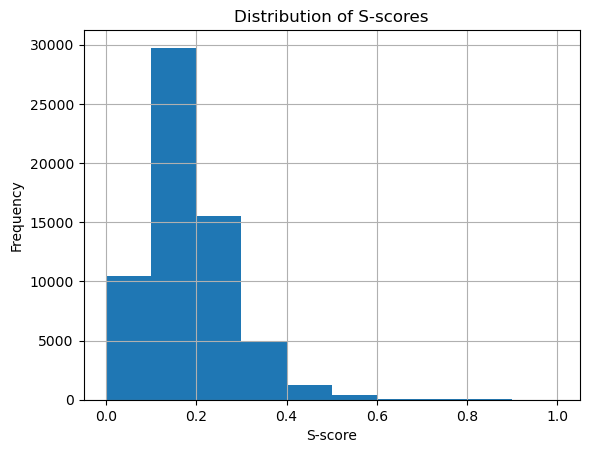

In [18]:
df['sscore'].hist(bins=10)
plt.title('Distribution of S-scores')
plt.xlabel('S-score')
plt.ylabel('Frequency')
plt.show()

# Include in-depth analysis into your results.

A high score may indicate an active economy and a booming real estate market, while a low score may indicate a weak economy

# Determine if there is any correlation between your score and the median income of each region

Non-significant linear relationship: The figure shows that there is a lack of strong linear correlation between median income and S-score overall, although high-income regions tend to have higher S-score

   sa22016code    sscore
0    111031222  0.277070
1    107031136  0.301037
2    107031137  0.247125
3    109011172  0.185323
4    109011172  0.087453


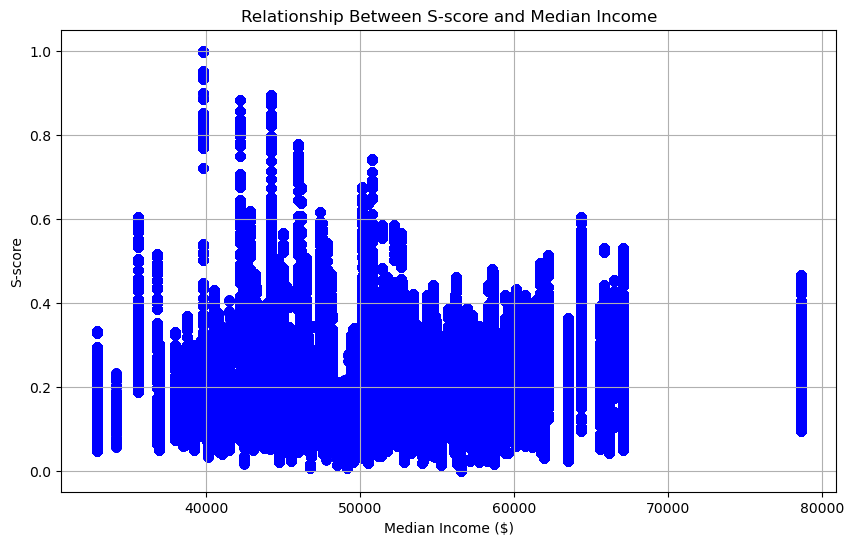

In [19]:
query = """
SELECT 
    p.sa22016code, 
    i.median_income
FROM 
    property p
JOIN 
    income i ON CAST(p.sa22016code AS VARCHAR) = CAST(i.sa2_code AS VARCHAR);
"""

# Execute the query and load into a DataFrame
df2 = pd.read_sql(query, db)
merged_df = pd.merge(df, df2, on='sa22016code', how='inner')

# Check the first few rows of the dataframe
print(df.head())

# Create a scatter plot to visualize the relationship between S-score and median income
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['median_income'], merged_df['sscore'], alpha=0.5, color='blue')  # alpha for transparency
plt.title('Relationship Between S-score and Median Income')
plt.xlabel('Median Income ($)')
plt.ylabel('S-score')
plt.grid(True)
plt.show()